Import Libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import threading
import queue
import sys
from skimage import io, transform
import os
from __future__ import division
from torch.nn import functional as F
import torch.optim as optim
import argparse
from datetime import datetime
import easydict

Define repetitve functions

In [ ]:
def create_variable(size, initiliaze=False):
    variable = nn.Parameter(torch.zeros(size, dtype=torch.float))
    nn.init.xavier_uniform_(variable.data)
    return variable


def uniform(shape, scale=0.05):
    """Uniform init."""
    variable = nn.Parameter(torch.zeros(shape, dtype=torch.float))
    nn.init.uniform_(variable.data, a=-scale, b=scale)
    return variable


def glorot(shape):
    variable = nn.Parameter(torch.zeros(shape, dtype=torch.float))
    nn.init.xavier_uniform_(variable.data)
    return variable


def zeros(shape):
    """All zeros."""
    variable = nn.Parameter(torch.zeros(shape, dtype=torch.float))
    return variable


def ones(shape, name=None):
    """All ones."""
    variable = nn.Parameter(torch.ones(shape, dtype=torch.float))
    return variable

Class to load the Data

In [ ]:
class DataFetcher(threading.Thread):

    def __init__(self, file_list, stereo=False, compute_f1=-1):
        super(DataFetcher, self).__init__()
        self.work = self.work_non_stereo
        self.stopped = False
        self.queue = queue.Queue(64)

        self.pkl_list = []
        with open(file_list, 'r+', encoding="utf-8") as f:
            while (True):
                line = f.readline().strip()
                if not line:
                    break
                if (not stereo) and os.path.isfile(line):
                    self.pkl_list.append(line)
                if stereo and all([os.path.isfile(l) for l in line.split(',')]):
                    self.pkl_list.append(line)
        np.random.shuffle(self.pkl_list)
        if compute_f1 > 0:
            self.pkl_list = self.pkl_list[:compute_f1]
        self.index = 0
        self.number = len(self.pkl_list)

    def work_non_stereo(self, idx):
        pkl_path = self.pkl_list[idx]
        label = pickle.load(open(pkl_path, 'rb'), encoding='bytes')
        img_path = pkl_path.replace('.dat', '.png')
        img = io.imread(img_path)
        img[np.where(img[:, :, 3] == 0)] = 255
        img = transform.resize(img, (224, 224))
        img = img[:, :, :3].astype('float32')

        return img, label, pkl_path.split('/')[-1]

    def run(self):
        while self.index < 90000000 and not self.stopped:
            self.queue.put(self.work(self.index % self.number))
            self.index += 1
            if self.index % self.number == 0:
                np.random.shuffle(self.pkl_list)

    def fetch(self):
        if self.stopped:
            return None
        return self.queue.get()

    def shutdown(self):
        self.stopped = True
        while not self.queue.empty():
            self.queue.get()

Perform the projection of features onto vertices

In [ ]:
def project(img_feat, x, y, dim):
    img_size = img_feat.shape[-1]

    x = torch.clamp(x, min=0, max=img_size - 1)
    y = torch.clamp(y, min=0, max=img_size - 1)

    x1 = torch.floor(x).long()
    x2 = torch.ceil(x).long()
    y1 = torch.floor(y).long()
    y2 = torch.ceil(y).long()

    Q11 = img_feat[:, x1, y1].clone()
    Q12 = img_feat[:, x1, y2].clone()
    Q21 = img_feat[:, x2, y1].clone()
    Q22 = img_feat[:, x2, y2].clone()

    weights = torch.mul(x2.float() - x, y2.float() - y)
    Q11 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q11, 0, 1))

    weights = torch.mul(x2.float() - x, y - y1.float())
    Q12 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q12, 0, 1))

    weights = torch.mul(x - x1.float(), y2.float() - y)
    Q21 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q21, 0, 1))

    weights = torch.mul(x - x1.float(), y - y1.float())
    Q22 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q22, 0, 1))

    outputs = sum([Q11, Q21, Q12, Q22])
    return outputs

Helper function for matrix multiplication

In [ ]:
def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = torch.matmul(x.to_dense(), y)
    else:
        res = torch.matmul(x, y)
    return res

Graph Convolution Block

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 tensor_dict,
                 act=F.relu,
                 bias=True,
                 gcn_block_id=1,
                 featureless=False):
        super(GraphConvolution, self).__init__()
        self.layer_type = 'GraphConvolution'

        self.act = act
        if gcn_block_id == 1:
            self.support = tensor_dict['support1']
        elif gcn_block_id == 2:
            self.support = tensor_dict['support2']
        elif gcn_block_id == 3:
            self.support = tensor_dict['support3']

        self.featureless = featureless
        self.bias = bias
        self.vars = nn.ParameterDict()
        for i in range(len(self.support)):
            self.vars['weights_' + str(i)] = glorot([input_dim, output_dim])
        if self.bias:
            self.vars['bias'] = zeros([output_dim])

    def forward(self, inputs):
        x = inputs
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)], sparse=False)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = sum(supports)
        # bias
        if self.bias:
            output += self.vars['bias']

        if self.act is not None:
            output = self.act(output)
        return output

Graph Pooling to modify the size of the working mesh

In [ ]:
class GraphPooling(nn.Module):
    """Graph Pooling layer."""

    def __init__(self, tensor_dict, pool_id=1):
        super(GraphPooling, self).__init__()
        self.layer_type = 'GraphPooling'
        self.pool_idx = tensor_dict['pool_idx'][pool_id - 1]

    def forward(self, inputs):
        X = inputs.clone()
        add_feat = (1 / 2.0) * X[:, self.pool_idx].sum(2)
        output = torch.cat([inputs, add_feat], dim=1)
        return output

Project the image features onto the mesh

In [ ]:
class GraphProjection(nn.Module):
    """Graph Projection layer."""

    def __init__(self):
        super(GraphProjection, self).__init__()
        self.layer_type = 'GraphProjection'

    def _prepare(self, img_feat):
        self.img_feat = img_feat

    def forward(self, inputs):
        outputs = []
        #print('inputs', inputs.shape)
        for idx, input_solo in enumerate(inputs):
            img_feat = [feats[idx] for feats in self.img_feat]
            output = self.forward_solo(inputs[0], img_feat)
            outputs.append(output)
        outputs = torch.stack(outputs, 0)
        return outputs

    def forward_solo(self, inputs, img_feat_solo):
        coord = inputs

        X = inputs[:, 0]
        Y = inputs[:, 1]
        Z = inputs[:, 2]

        h = 250 * torch.div(-Y, -Z) + 112
        w = 250 * torch.div(X, -Z) + 112

        h = torch.clamp(h, min=0, max=223)
        w = torch.clamp(w, min=0, max=223)

        x = h / (224.0 / 56)
        y = w / (224.0 / 56)

        out1 = project(img_feat_solo[0], x, y, 64)

        x = h / (224.0 / 28)
        y = w / (224.0 / 28)
        out2 = project(img_feat_solo[1], x, y, 128)

        x = h / (224.0 / 14)
        y = w / (224.0 / 14)
        out3 = project(img_feat_solo[2], x, y, 256)

        x = h / (224.0 / 7)
        y = w / (224.0 / 7)

        out4 = project(img_feat_solo[3], x, y, 512)

        outputs = torch.cat([coord, out1, out2, out3, out4], 1)
        #print('OUTPUT', outputs.shape)
        return outputs

Define chamfer distance used to calculate vertex loss

In [ ]:
def pairwise_dist(x, y):
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = xx.diag().unsqueeze(0).expand_as(xx)
    ry = yy.diag().unsqueeze(0).expand_as(yy)
    P = rx.t() + ry - 2 * zz
    return P


def NN_loss(x, y, dim=0):
    dist = pairwise_dist(x, y)
    values, indices = dist.min(dim=dim)
    return values.mean()


def distChamfer(a, b):
    x, y = a.double(), b.double()
    bs, num_points_x, points_dim = x.size()
    bs, num_points_y, points_dim = y.size()

    xx = torch.pow(x, 2).sum(2)
    yy = torch.pow(y, 2).sum(2)
    zz = torch.bmm(x, y.transpose(2, 1))
    rx = xx.unsqueeze(1).expand(bs, num_points_y,
                                num_points_x)  # Diagonal elements xx
    ry = yy.unsqueeze(1).expand(bs, num_points_x,
                                num_points_y)  # Diagonal elements yy
    P = rx.transpose(2, 1) + ry - 2 * zz
    return torch.min(P, 2)[0].float(), torch.min(P, 1)[0].float(), torch.min(
        P, 2)[1].int(), torch.min(P, 1)[1].int()


def chamfer_dist(a, b):
    if len(a.shape) == 3:
        return distChamfer(a, b)
    else:
        dist1, dist2, idx1, idx2 = distChamfer(a.unsqueeze(0), b.unsqueeze(0))
        return dist1.squeeze(0), dist2.squeeze(0), idx1.squeeze(
            0), idx2.squeeze(0)

Define the losses - vertex, edge and face

In [ ]:
def laplace_coord(pred, tensor_dict, block_id):
    vertex = torch.cat([pred, torch.zeros((1, 3))], dim=0)
    indices = tensor_dict['lape_idx'][block_id - 1][:, :8].long()
    weights = tensor_dict['lape_idx'][block_id - 1][:, -1].float()
    weights = torch.repeat_interleave(torch.reshape(torch.reciprocal(weights),
                                                    [-1, 1]),
                                      repeats=3,
                                      dim=1)

    laplace = torch.sum(vertex[indices], dim=1)
    laplace = pred - torch.mul(weights, laplace)
    return laplace

def laplace_loss(pred1, pred2, tensor_dict, block_id):
    # laplace term
    lap1 = laplace_coord(pred1, tensor_dict, block_id)
    lap2 = laplace_coord(pred2, tensor_dict, block_id)
    laplace_loss = torch.mean(torch.sum(torch.pow(lap1 - lap2, 2), 1)) * 1500
    if block_id == 1:
        move_loss = torch.mean(torch.sum(torch.pow(pred1 - pred2, 2), 1)) * 100
        laplace_loss += move_loss
    return laplace_loss


def unit(tensor):
    return F.normalize(tensor, p=2, dim=1)


def mesh_loss(pred, labels, tensor_dict, block_id):
    gt_pt = labels[:, :3]  # gt points
    gt_nm = labels[:, 3:]  # gt normals

    # edge in graph
    nod1 = torch.index_select(pred, 0, tensor_dict['edges'][block_id - 1][:, 0])
    nod2 = torch.index_select(pred, 0, tensor_dict['edges'][block_id - 1][:, 1])
    edge = nod1 - nod2

    # edge length loss
    edge_length = torch.sum(torch.pow(edge, 2), dim=1)
    edge_loss = torch.mean(edge_length) * 300

    # chamer distance
    dist1, dist2, idx1, idx2 = chamfer_dist(gt_pt, pred)
    point_loss = (torch.mean(dist1) + 0.55 * torch.mean(dist2)) * 3000

    # normal cosine loss
    normal = torch.index_select(pred, 0, idx1.long())
    #normal = gt_nm[:, idx2.long()]
    normal = torch.index_select(normal, 0,
                                tensor_dict['edges'][block_id - 1][:, 0])
    #normal = normal[:, tensor_dict['edges'][block_id - 1][:, 0]]
    cosine = torch.abs(torch.sum(torch.mul(unit(normal), unit(edge)), 1))
    # cosine = tf.where(tf.greater(cosine,0.866), tf.zeros_like(cosine), cosine) # truncated
    normal_loss = torch.mean(cosine) * 0.5

    total_loss = point_loss + edge_loss + normal_loss
    return total_loss

Construction of the initial ellipsoid mesh and saving the final mesh

In [ ]:
class AttributeDict(dict):

    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value


def convert_dict(d):
    new_d = AttributeDict()
    new_d.update(d)
    return new_d


def create_sparse_tensor(info):
    indices = torch.LongTensor(info[0])
    values = torch.FloatTensor(info[1])
    shape = torch.Size(info[2])
    sparse_tensor = torch.sparse.FloatTensor(indices.t(), values, shape)
    return sparse_tensor


def construct_ellipsoid_info_pkl(pkl):
    """Ellipsoid info in numpy and tensor types"""
    coord = pkl[0]
    pool_idx = pkl[4]
    faces = pkl[5]
    lape_idx = pkl[7]

    edges = []
    for i in range(1, 4):
        adj = pkl[i][1]
        edges.append(adj[0])
    for i in range(3):
        idx = lape_idx[i].shape[0]
        np.place(lape_idx[i], lape_idx[i] == -1, idx)
    info_dict = {
        'features': coord,
        'edges': edges,
        'faces': faces,
        'pool_idx': pool_idx,
        'lape_idx': lape_idx,
        'support1': pkl[1],
        'support2': pkl[2],
        'support3': pkl[3]
    }
    return convert_dict(info_dict)


def construct_ellipsoid_info(args):
    pkl = pickle.load(open(args.info_ellipsoid, 'rb'), encoding='bytes')
    info_dict = construct_ellipsoid_info_pkl(pkl)
    tensor_dict = {
            'features':
                torch.from_numpy(info_dict.features),
            'edges': [torch.from_numpy(e).long() for e in info_dict.edges],
            'faces':
                info_dict.faces,
            'pool_idx':
                info_dict.pool_idx,
            'lape_idx': [
                torch.from_numpy(l).float() for l in info_dict.lape_idx
            ],
            'support1': [
                create_sparse_tensor(info) for info in info_dict.support1
            ],
            'support2': [
                create_sparse_tensor(info) for info in info_dict.support2
            ],
            'support3': [
                create_sparse_tensor(info) for info in info_dict.support3
            ]
        }
    return tensor_dict


def get_features(tensor_dict, images):
    if len(images.shape) == 4:
        batch_size = int(images.shape[0])
        return tensor_dict['features'].data.unsqueeze(0).expand(
            batch_size, -1, -1)
    else:
        return tensor_dict['features']


def load_image(img_path):
    img = io.imread(img_path)
    if img.shape[2] == 4:
        img[np.where(img[:, :, 3] == 0)] = 255
    img = transform.resize(img, (224, 224))
    img = img[:, :, :3].astype('float32')
    img_inp = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
    return img_inp


def process_input(img_inp, y_train):
    img_inp = torch.from_numpy(img_inp).permute(2, 0, 1).float()
    y_train = torch.from_numpy(y_train)
    return img_inp, y_train


def process_output(output3):
    vert = output3.detach().cpu().numpy()[0]
    vert = np.hstack((np.full([vert.shape[0], 1], 'v'), vert))
    face = np.loadtxt('/content/drive/MyDrive/Data/face3.obj', dtype='|S32')
    mesh = np.vstack((vert, face))
    return mesh

Define loss and optimizer for the model

In [ ]:
class Trainer:

    def __init__(self, tensor_dict, network, args):
        self.args = args
        self.network = network

        self.optimizer = optim.Adam(network.parameters(),
                                    lr=self.args.learning_rate,
                                    weight_decay=self.args.weight_decay)
        self.tensor_dict = tensor_dict
        self._get_loss = self._get_loss_pt

    def decay_lr(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= self.args.learning_rate_decay

    def get_loss(self, img_inp, labels):
        if type(img_inp) != list:
            batch = len(img_inp.shape) == 4
            inputs = get_features(self.tensor_dict, img_inp)
            outputs = self.network(img_inp)
        else:
            batch = len(img_inp[0].shape) == 4
            inputs = get_features(self.tensor_dict, img_inp[0])
            outputs = self.network(img_inp[0], img_inp[1])
        if batch:
            loss = 0
            for idx, (input, label) in enumerate(zip(inputs, labels)):
                output = [out[idx] for out in outputs]
                loss += self._get_loss(input, output, label)
            loss /= len(inputs)
        else:
            loss = self._get_loss(inputs, outputs, labels)
        return loss, outputs[0], outputs[2], outputs[4]

    def _get_loss_tf(self, inputs, outputs, labels):
        #output1, output1_2, output2, output2_2, output3 = outputs
        loss = 0
        loss += mesh_loss(outputs[0], labels, self.tensor_dict, 1)
        loss += mesh_loss(outputs[2], labels, self.tensor_dict, 2)
        loss += mesh_loss(outputs[4], labels, self.tensor_dict, 3)
        loss += .1 * laplace_loss(inputs, outputs[0], self.tensor_dict, 1)
        loss += laplace_loss(outputs[1], outputs[2], self.tensor_dict, 2)
        loss += laplace_loss(outputs[3], outputs[4], self.tensor_dict, 3)
        for layer in self.network.layers:
            if layer.layer_type == 'GraphConvolution':
                for key, var in layer.vars.items():
                    loss += self.args.weight_decay * torch.sum(var**2)
        return loss

    def _get_loss_pt(self, inputs, outputs, labels):
        # Edge Loss
        def edge_loss_pt(pred, labels, tensor_dict, block_id):
            gt_pts = labels[:, :3]
            idx1 = tensor_dict['edges'][block_id - 1][:, 0]
            idx2 = tensor_dict['edges'][block_id - 1][:, 0]
            nod1 = torch.index_select(pred, 0, idx1)
            nod2 = torch.index_select(pred, 0, idx2)
            edge = nod1 - nod2
            # edge length loss
            edge_length = torch.sum(torch.pow(edge, 2), 1)
            edge_loss = torch.mean(edge_length) * 300
            return edge_loss

        def laplace_coord(input, tensor_dict, block_id):

            vertex = torch.cat(
                (input,
                 torch.zeros(1, 3).cuda()), 0) if False else torch.cat(
                     (input, torch.zeros(1, 3)), 0)

            indices = tensor_dict['lape_idx'][block_id - 1][:, :8].long()

            weights = tensor_dict['lape_idx'][block_id - 1][:, -1].float()

            weights = torch.reciprocal(weights).reshape((-1, 1)).repeat((1, 3))

            num_pts, num_indices = indices.shape[0], indices.shape[1]
            indices = indices.reshape((-1,))
            vertices = torch.index_select(vertex, 0, indices)
            vertices = vertices.reshape((num_pts, num_indices, 3))

            laplace = torch.sum(vertices, 1)
            laplace = input - torch.mul(laplace, weights)

            return laplace

        def laplace_loss(input1, input2, tensor_dict, block_id):

            lap1 = laplace_coord(input1, tensor_dict, block_id)
            lap2 = laplace_coord(input2, tensor_dict, block_id)
            laplace_loss = torch.mean(torch.sum(torch.pow(lap1 - lap2, 2),
                                                1)) * 1500
            move_loss = torch.mean(torch.sum(torch.pow(input1 - input2, 2),
                                             1)) * 100

            if block_id == 1:
                return laplace_loss
            else:
                return laplace_loss + move_loss
            # Chamfer Loss

        pt_chamfer_loss = 0.
        pt_edge_loss = 0.
        pt_lap_loss = 0.
        lap_const = [0.2, 1., 1.]
        for idx, (output, feat) in enumerate(
                zip([outputs[0], outputs[2], outputs[4]],
                    [inputs, outputs[1], outputs[3]])):
            dist1, dist2, _, _ = chamfer_dist(output, labels[:, :3])
            pt_chamfer_loss += torch.mean(dist1) + torch.mean(dist2)
            pt_edge_loss += edge_loss_pt(output, labels, self.tensor_dict,
                                         idx + 1)
            pt_lap_loss += lap_const[idx] * laplace_loss(
                feat, output, self.tensor_dict, idx + 1)

        loss = 100 * pt_chamfer_loss + 0.1 * pt_edge_loss + 0.3 * pt_lap_loss
        return loss

    def optimizer_step(self, images, labels):
        self.optimizer.zero_grad()
        loss, output1, output2, output3 = self.get_loss(images, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item(), output1.detach().numpy(), output2.detach(
            ).numpy(), output3.detach().numpy()

Build the structure for running the model

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.layers = []

    def _prepare(self, img_feat):
        for layer in self.proj_layers:
            layer._prepare(img_feat)

    def _build(self):
        raise NotImplementedError

    def build(self):
        self._build()
        self.unpool_layers = []
        self.unpool_layers.append(
            GraphPooling(tensor_dict=self.tensor_dict, pool_id=1))
        self.unpool_layers.append(
            GraphPooling(tensor_dict=self.tensor_dict, pool_id=2))

    def forward(self, img_inp, img_bis=None):
        reshape = len(img_inp.shape) == 3
        if reshape:
            img_inp = img_inp.unsqueeze(0)
        inputs = get_features(self.tensor_dict, img_inp)

        img_feat = self.forward_cnn(img_inp)

        self._prepare(img_feat)

        # Build sequential resnet model
        eltwise = [
            3, 5, 7, 9, 11, 13, 19, 21, 23, 25, 27, 29, 35, 37, 39, 41, 43, 45
        ]
        concat = [15, 31]

        activations = []
        activations.append(inputs)

        for idx, layer in enumerate(self.layers):
            hidden = layer(activations[-1])
            if idx in eltwise:
                hidden = torch.add(hidden, activations[-2]) * 0.5
            if idx in concat:
                hidden = torch.cat([hidden, activations[-2]], 2)
            activations.append(hidden)

        output1 = activations[15]
        output1_2 = self.unpool_layers[0](output1)

        output2 = activations[31]
        output2_2 = self.unpool_layers[1](output2)

        output3 = activations[-1]
        if not reshape:
            return output1, output1_2, output2, output2_2, output3
        else:
            return output1.squeeze(0), output1_2.squeeze(0), output2.squeeze(
                0), output2_2.squeeze(0), output3.squeeze(0)

Define all the layers - Image Feature Network and the Mesh Deformation

In [ ]:
class GCN(Model):

    def __init__(self, tensor_dict, args):
        super(GCN, self).__init__()
        self.tensor_dict = tensor_dict
        self.args = args
        if self.args.cnn_type == 'RES':
            self.forward_cnn = self.forward_res
            self.build_cnn = self.build_res
        self.build()

    def _build(self):
        FLAGS = self.args
        self.build_cnn()
        # first project block
        self.layers.append(GraphProjection())
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.feat_dim,
                             output_dim=FLAGS.hidden,
                             gcn_block_id=1,
                             tensor_dict=self.tensor_dict))

        for _ in range(12):
            self.layers.append(
                GraphConvolution(input_dim=FLAGS.hidden,
                                 output_dim=FLAGS.hidden,
                                 gcn_block_id=1,
                                 tensor_dict=self.tensor_dict))
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.hidden,
                             output_dim=FLAGS.coord_dim,
                             act=None,
                             gcn_block_id=1,
                             tensor_dict=self.tensor_dict))

        # second project block
        self.layers.append(GraphProjection())
        self.layers.append(GraphPooling(tensor_dict=self.tensor_dict,
                                        pool_id=1))  # unpooling
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.feat_dim + FLAGS.hidden,
                             output_dim=FLAGS.hidden,
                             gcn_block_id=2,
                             tensor_dict=self.tensor_dict))
        for _ in range(12):
            self.layers.append(
                GraphConvolution(input_dim=FLAGS.hidden,
                                 output_dim=FLAGS.hidden,
                                 gcn_block_id=2,
                                 tensor_dict=self.tensor_dict))
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.hidden,
                             output_dim=FLAGS.coord_dim,
                             act=None,
                             gcn_block_id=2,
                             tensor_dict=self.tensor_dict))
        # third project block
        self.layers.append(GraphProjection())
        self.layers.append(GraphPooling(tensor_dict=self.tensor_dict,
                                        pool_id=2))  # unpooling
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.feat_dim + FLAGS.hidden,
                             output_dim=FLAGS.hidden,
                             gcn_block_id=3,
                             tensor_dict=self.tensor_dict))
        for _ in range(12):
            self.layers.append(
                GraphConvolution(input_dim=FLAGS.hidden,
                                 output_dim=FLAGS.hidden,
                                 gcn_block_id=3,
                                 tensor_dict=self.tensor_dict))
        self.layers.append(
            GraphConvolution(input_dim=FLAGS.hidden,
                             output_dim=int(FLAGS.hidden / 2),
                             gcn_block_id=3,
                             tensor_dict=self.tensor_dict))
        self.layers.append(
            GraphConvolution(input_dim=int(FLAGS.hidden / 2),
                             output_dim=FLAGS.coord_dim,
                             act=None,
                             gcn_block_id=3,
                             tensor_dict=self.tensor_dict))
        self.layers = nn.ModuleList(self.layers)

        self.proj_layers = []
        for layer in self.layers:
            if layer.layer_type == 'GraphProjection':
                self.proj_layers.append(layer)

    def build_res(self):
        self.cnn_layers_01 = [ nn.ZeroPad2d(1), nn.Conv2d(3, 16, 3, 1, padding=0), nn.ReLU()]
        self.cnn_layers_02 = [ nn.ZeroPad2d(1), nn.Conv2d(16, 16, 3, 1, padding=0), nn.ReLU()]
        self.cnn_layers_11 = [ nn.ZeroPad2d((0, 1, 0, 1)), nn.Conv2d(16, 32, 3, 2, padding=0), nn.ReLU()]
        # 112 112
        self.cnn_layers_12 = [ nn.ZeroPad2d(1), nn.Conv2d(32, 32, 3, 1, padding=0), nn.ReLU()]
        self.cnn_layers_13 = [ nn.ZeroPad2d(1), nn.Conv2d(32, 32, 3, 1, padding=0), nn.ReLU()]
        self.cnn_layers_21 = [ nn.ZeroPad2d((0, 1, 0, 1)), nn.Conv2d(32, 64, 3, 2, padding=0), nn.ReLU()]
        # 56 56
        self.cnn_layers_22 = [ nn.ZeroPad2d(1), nn.Conv2d(64, 64, 3, 1, padding=0), nn.ReLU()]
        self.cnn_layers_23 = [ nn.ZeroPad2d(1), nn.Conv2d(64, 64, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_31 = [ nn.ZeroPad2d((0, 1, 0, 1)), nn.Conv2d(64, 128, 3, 2, padding=0), nn.ReLU()]
        # 28 28
        self.cnn_layers_32 = [ nn.ZeroPad2d(1), nn.Conv2d(128, 128, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_33 = [ nn.ZeroPad2d(1), nn.Conv2d(128, 128, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_41 = [ nn.ZeroPad2d((1, 2, 1, 2)), nn.Conv2d(128, 256, 5, 2, padding=0), nn.ReLU() ]
        # 14 14
        self.cnn_layers_42 = [ nn.ZeroPad2d(1), nn.Conv2d(256, 256, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_43 = [ nn.ZeroPad2d(1), nn.Conv2d(256, 256, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_51 = [ nn.ZeroPad2d((1, 2, 1, 2)), nn.Conv2d(256, 512, 5, 2, padding=0), nn.ReLU() ]
        # 7 7
        self.cnn_layers_52 = [ nn.ZeroPad2d(1), nn.Conv2d(512, 512, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_53 = [ nn.ZeroPad2d(1), nn.Conv2d(512, 512, 3, 1, padding=0), nn.ReLU() ]
        self.cnn_layers_54 = [ nn.ZeroPad2d(1), nn.Conv2d(512, 512, 3, 1, padding=0), nn.ReLU() ]
        keys = list(self.__dict__.keys())[:]
        for key in keys:
            if key.startswith('cnn_layers_'):
                setattr(self, key, nn.Sequential(*getattr(self, key)))

    def forward_res(self, img_inp):
        x = img_inp
        x = self.cnn_layers_01(x)
        x = self.cnn_layers_02(x)
        x0 = x
        x = self.cnn_layers_11(x)
        x_res = x
        x = self.cnn_layers_12(x)
        x = self.cnn_layers_13(x) + x_res
        x1 = x
        x = self.cnn_layers_21(x)
        x_res = x
        x = self.cnn_layers_22(x)
        x = self.cnn_layers_23(x) + x_res
        x2 = x
        x = self.cnn_layers_31(x)
        x_res = x
        x = self.cnn_layers_32(x)
        x = self.cnn_layers_33(x) + x_res
        x3 = x
        x = self.cnn_layers_41(x)
        x_res = x
        x = self.cnn_layers_42(x)
        x = self.cnn_layers_43(x) + x_res
        x4 = x
        x = self.cnn_layers_51(x)
        x_res = x
        x = self.cnn_layers_52(x)
        x = self.cnn_layers_53(x) + x_res
        x = self.cnn_layers_54(x)
        x5 = x
        img_feat = [x2, x3, x4, x5]
        return img_feat

Configure the parameters for the model

In [ ]:
# Set random seed
seed = 1024
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.empty_cache()

# Settings
args = easydict.EasyDict({
    'training_data': '/content/drive/MyDrive/Data/train.txt',
    'testing_data' : '/content/drive/MyDrive/Data/test_list.txt',
    'batch_size' : 30,
    'learning_rate' : 5e-5,
    'learning_rate_decay' : 0.97,
    'learning_rate_every' : 2,
    'show_every' : 5,
    'weight_decay' : 1e-5,
    'epochs' : 20,
    'cnn_type' : 'RES',
    'checkpoint' : '/content/drive/MyDrive/Data/checkpoint_start.pt',
    'info_ellipsoid' : '/content/drive/MyDrive/Data/info_ellipsoid.dat',
    'hidden' : 256,
    'feat_dim' : 963,
    'coord_dim' : 3
})

Build the model

In [ ]:
FLAGS = args
tensor_dict = construct_ellipsoid_info(FLAGS)
print('---- Build initial ellispoid info')

model = GCN(tensor_dict, FLAGS)
print('---- Model Created')

---- Build initial ellispoid info
---- Model Created


In [ ]:
!7z x /content/drive/MyDrive/Data/pixel2mesh/ShapeNetP2M.7z.001


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Data/pixel2mesh/                                                 1 file, 8522825728 bytes (8128 MiB)

Extracting archive: /content/drive/MyDrive/Data/pixel2mesh/ShapeNetP2M.7z.001
  0% 1 Open           --
Path = /content/drive/MyDrive/Data/pixel2mesh/ShapeNetP2M.7z.001
Type = Split
Physical Size = 8522825728
Volumes = 4
Total Physical Size = 31189146996
----
Path = ShapeNetP2M.7z
Size = 31189146996
--
Path = ShapeNetP2M.7z
Type = 7z
Physical Size = 31189146996
Headers Size = 138
Method = Copy
Solid = -
Blocks = 1

  0%      0% - ShapeNetP2M.tgz                      

In [ ]:
!tar -xvf  'ShapeNetP2M.tgz' -C 'Data'

Streaming output truncated to the last 5000 lines.
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/04.png
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/01.png
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/02.png
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/03.png
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/00.dat
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/00.png
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/01.dat
ShapeNetP2M/03001627/7eb4a453070b3f090d1267f8054d8a8/rendering/04.dat
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51f77a6d7299806/
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51f77a6d7299806/rendering/
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51f77a6d7299806/rendering/03.dat
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51f77a6d7299806/rendering/rendering_metadata.txt
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51f77a6d7299806/rendering/02.dat
ShapeNetP2M/03001627/30f4c4d94f4fcffaf51

Train the model

In [ ]:
data = DataFetcher(FLAGS.training_data)
data.setDaemon(True)
data.start()
train_number = data.number
print('---- Loading training data')

test_list = []
with open(FLAGS.testing_data, 'r+', encoding="utf-8") as f:
    while (True):
        line = f.readline().strip()
        if not line:
            break
        id = line.split('/')[-1][:-4]
        test_list.append((id, load_image(line)))
print('---- Loading testing data')
model.load_state_dict(torch.load(FLAGS.checkpoint,
                                     map_location=torch.device('cpu')),
                          strict=False)
print('---- Model initialized')

trainer = Trainer(tensor_dict, model, FLAGS)
print('---- Trainer Created')

<ipython-input-32-b4465c6b6f4c>:2: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  data.setDaemon(True)


---- Loading training data
---- Loading testing data
---- Model initialized
---- Trainer Created


In [ ]:
print('---- Training ...')
print('\n')
mydir = '/content/drive/MyDrive/Data/TrainedModel'
starter = datetime.now()
for epoch in range(FLAGS.epochs):
    if (epoch + 1) % FLAGS.learning_rate_every == 0:
        trainer.decay_lr()
    start_epoch = datetime.now()
    timer = start_epoch
    epoch_dir = mydir + '/epoch_{}'.format(epoch + 1)
    os.makedirs(epoch_dir)
    os.makedirs(epoch_dir + '/outputs')
    print('-------- Folder created : {}'.format(epoch_dir))
    all_loss = np.zeros(int(train_number / FLAGS.batch_size), dtype='float32')
    print('-------- Training epoch {} ...'.format(epoch + 1))
    for iters in range(int(train_number / FLAGS.batch_size)):
        torch.cuda.empty_cache()
        start_iter = datetime.now()
        if FLAGS.batch_size == 1:
            img_inp, y_train, data_id = data.fetch()
            img_inp, y_train = process_input(img_inp, y_train)
            dists, out1, out2, out3 = trainer.optimizer_step(img_inp, y_train)
            all_loss[iters] = dists
            mean_loss = np.mean(all_loss[np.where(all_loss)])
        else:
            #print('NUM ITERATION ==', iters)
            img_inp, y_train = [], []
            for bla in range(FLAGS.batch_size):
                sample = data.fetch()
                sample = process_input(sample[0], sample[1])
                y_train.append(sample[1])
                img_inp.append(sample[0])

            img_inp = torch.stack(img_inp)
            dists, out1, out2, out3 = trainer.optimizer_step(img_inp, y_train)
            all_loss[iters] = dists
            mean_loss = np.mean(all_loss[np.where(all_loss)])
        end_iter = datetime.now()
        if (iters + 1) % FLAGS.show_every == 0:
            print(
                '------------  mean loss = {:.2f}, iter loss = {:.2f}'
                .format( mean_loss, dists))

    print('-------- Training epoch {} done !'.format(epoch + 1))

    ckp_dir = epoch_dir + '/last_checkpoint.pt'
    torch.save(model.state_dict(), ckp_dir)
    print('-------- Training checkpoint last saved !')

    print('-------- Testing epoch {} ...'.format(epoch + 1))
    for id, img_test in test_list:
        output3 = model(img_test)[-1]
        mesh = process_output(output3)
        pred_path = epoch_dir + '/outputs/' + id + '.obj'
        np.savetxt(pred_path, mesh, fmt='%s', delimiter=' ')
    print('-------- Testing epoch {} done !'.format(epoch + 1))
    print('\n')

---- Training ...


-------- Folder created : /content/drive/MyDrive/Data/TrainedModel/epoch_1
-------- Training epoch 1 ...
------------  mean loss = 0.07, iter loss = 0.07
------------  mean loss = 0.07, iter loss = 0.06
------------  mean loss = 0.07, iter loss = 0.09
------------  mean loss = 0.07, iter loss = 0.07
------------  mean loss = 0.07, iter loss = 0.07
-------- Training epoch 1 done !
-------- Training checkpoint last saved !
-------- Testing epoch 1 ...
-------- Testing epoch 1 done !


-------- Folder created : /content/drive/MyDrive/Data/TrainedModel/epoch_2
-------- Training epoch 2 ...
------------  mean loss = 0.09, iter loss = 0.09
------------  mean loss = 0.08, iter loss = 0.07
------------  mean loss = 0.10, iter loss = 0.12
------------  mean loss = 0.10, iter loss = 0.13
------------  mean loss = 0.10, iter loss = 0.07
-------- Training epoch 2 done !
-------- Training checkpoint last saved !
-------- Testing epoch 2 ...
-------- Testing epoch 2 done !


----

Evaluation

In [ ]:
# Set random seed
seed = 1024
np.random.seed(seed)
torch.manual_seed(seed)

# Settings
args = easydict.EasyDict({
    'num_samples' : 10,
    'f1_data' : '/content/drive/MyDrive/Data/f1_list.txt',
    'cnn_type' : 'RES',
    'checkpoint' : '/content/drive/MyDrive/Data/last_checkpoint_res.pt',
    'info_ellipsoid' : '/content/drive/MyDrive/Data/info_ellipsoid.dat',
    'hidden' : 256,
    'feat_dim' : 963,
    'coord_dim' : 3
})

FLAGS = args

tensor_dict = construct_ellipsoid_info(FLAGS)
print('---- Build initial ellispoid info')

model = GCN(tensor_dict, FLAGS)
print('---- Model Created')

<ipython-input-14-da724399228e>:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  sparse_tensor = torch.sparse.FloatTensor(indices.t(), values, shape)


---- Build initial ellispoid info
---- Model Created


In [ ]:
model.load_state_dict(torch.load(FLAGS.checkpoint,
                                     map_location=torch.device('cpu')),
                          strict=False)
print('---- Model loaded from checkpoint')

data = DataFetcher(FLAGS.f1_data,
                   stereo=FLAGS.cnn_type == 'STR',
                   compute_f1=FLAGS.num_samples)
data.setDaemon(True)
data.start()
data_number = data.number
print('---- Loading f1 data')


def fscore(d1, d2, threshold):
    precision_1 = torch.mean((dist1 < threshold).float())
    precision_2 = torch.mean((dist2 < threshold).float())
    f_score = 2 * precision_1 * precision_2 / (precision_1 + precision_2)
    return f_score.detach().cpu().item()


f1_tau, f2_tau = [], []
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    model.eval()
    all_dist_1, all_dist_2 = [], []
    for iters in range(data_number):
        torch.cuda.empty_cache()
        if FLAGS.cnn_type != 'STR':
            img_inp, y_train, data_id = data.fetch()
            img_inp, y_train = process_input(img_inp, y_train)
            pred_points = model(img_inp)[-1]
        gt_points = y_train[:, :3]
        dist1, dist2, _, _ = distChamfer(pred_points.unsqueeze(0),
                                             gt_points.unsqueeze(0))
        f1_tau.append(fscore(dist1, dist2, 0.0001))
        f2_tau.append(fscore(dist1, dist2, 0.0002))
        print('Sample = {}, f1_tau = {:.2f}, f1_2tau = {:.2f}'.format(
            iters + 1, f1_tau[-1], f2_tau[-1]))
    score_f1 = np.mean(f1_tau)
    print('------> threshold = {}, fscore = {}'.format(0.0001, score_f1))
    score_f2 = np.mean(f2_tau)
    print('------> threshold = {}, fscore = {}'.format(0.0002, score_f2))

---- Model loaded from checkpoint


<ipython-input-19-405c2dc5ad72>:9: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  data.setDaemon(True)


---- Loading f1 data
Sample = 1, f1_tau = 0.85, f1_2tau = 0.95
Sample = 2, f1_tau = 0.80, f1_2tau = 0.93
Sample = 3, f1_tau = 0.68, f1_2tau = 0.85
Sample = 4, f1_tau = 0.83, f1_2tau = 0.95
Sample = 5, f1_tau = 0.81, f1_2tau = 0.92
Sample = 6, f1_tau = 0.80, f1_2tau = 0.94
Sample = 7, f1_tau = 0.83, f1_2tau = 0.95
Sample = 8, f1_tau = 0.85, f1_2tau = 0.94
Sample = 9, f1_tau = 0.84, f1_2tau = 0.95
Sample = 10, f1_tau = 0.85, f1_2tau = 0.96
------> threshold = 0.0001, fscore = 0.8128351390361785
------> threshold = 0.0002, fscore = 0.933940851688385


In [ ]:
# Set random seed
seed = 1024
np.random.seed(seed)
torch.manual_seed(seed)

# Settings
args = easydict.EasyDict({
    'num_samples' : 10,
    'eval_data' : '/content/drive/MyDrive/Data/eval.txt',
    'cnn_type' : 'RES',
    'checkpoint' : '/content/drive/MyDrive/Data/last_checkpoint_res.pt',
    'info_ellipsoid' : '/content/drive/MyDrive/Data/info_ellipsoid.dat',
    'hidden' : 256,
    'feat_dim' : 963,
    'coord_dim' : 3
})

FLAGS = args

tensor_dict = construct_ellipsoid_info(FLAGS)
print('---- Build initial ellispoid info')

model = GCN(tensor_dict, FLAGS)
print('---- Model Created')

---- Build initial ellispoid info
---- Model Created


In [ ]:
#!pip install pyemd
#from pyemd import emd_samples,emd
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy import linalg

In [ ]:
model.load_state_dict(torch.load(FLAGS.checkpoint,
                                     map_location=torch.device('cpu')),
                          strict=False)
print('---- Model loaded from checkpoint')

data = DataFetcher(FLAGS.eval_data,
                   stereo=FLAGS.cnn_type == 'STR',
                   compute_f1=FLAGS.num_samples)
data.setDaemon(True)
data.start()
data_number = data.number
print('---- Loading eval data')


for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    model.eval()
    all_dist_1, all_dist_2 = [], []
    total = 0.0
    for iters in range(data_number):
        torch.cuda.empty_cache()
        if FLAGS.cnn_type != 'STR':
            img_inp, y_train, data_id = data.fetch()
            img_inp, y_train = process_input(img_inp, y_train)
            pred_points = model(img_inp)[-1]
        gt_points = y_train[:, :3]
        points1 = np.array(gt_points)
        points2 = np.array(pred_points)
        d = cdist(points1, points2)
        assignment = linear_sum_assignment(d)
        emd = (d[assignment].sum() / len(gt_points))*10
        print('Sample = {}, EMD = {:.4f}'.format(iters + 1, emd))
        total += emd
    print('Mean = {:.4f}'.format(total/data_number))

---- Model loaded from checkpoint
---- Loading eval data


<ipython-input-27-4049261ed07e>:9: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  data.setDaemon(True)


Sample = 1, EMD = 0.0238
Sample = 2, EMD = 0.0238
Sample = 3, EMD = 0.0448
Sample = 4, EMD = 0.0286
Sample = 5, EMD = 0.0149
Sample = 6, EMD = 0.0199
Sample = 7, EMD = 0.0623
Sample = 8, EMD = 0.0178
Sample = 9, EMD = 0.0340
Sample = 10, EMD = 0.0759
Mean = 0.0346


In [ ]:
import matplotlib.pyplot as plt

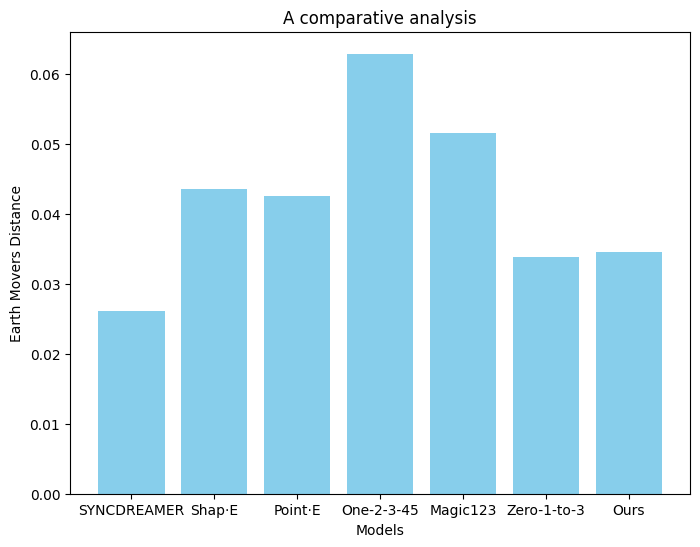

In [ ]:
labels = ['SYNCDREAMER', 'Shap·E', 'Point·E', 'One-2-3-45', 'Magic123', 'Zero-1-to-3', 'Ours']
values = [0.0261, 0.0436, 0.0426, 0.0629, 0.0516, 0.0339, 0.0346]


plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')


plt.xlabel('Models')
plt.ylabel('Earth Movers Distance')
plt.title('A comparative analysis')

# Show plot
plt.show()

In [ ]:
def inception_score(features1, features2):
    # Compute mean and standard deviation of features
    mean1, std1 = np.mean(features1, axis=0), np.std(features1, axis=0)
    mean2, std2 = np.mean(features2, axis=0), np.std(features2, axis=0)

    # Compute KL divergence for each feature dimension
    kl_divergence = np.mean(std1 * (np.log(std1) - np.log(std2)) + (mean1 - mean2)**2 / (2 * std2**2) - 0.5, axis=0)

    # Compute Inception Score
    is_score = np.exp(np.mean(kl_divergence))

    return is_score

In [ ]:
model.load_state_dict(torch.load(FLAGS.checkpoint,
                                     map_location=torch.device('cpu')),
                          strict=False)
print('---- Model loaded from checkpoint')

data = DataFetcher(FLAGS.eval_data,
                   stereo=FLAGS.cnn_type == 'STR',
                   compute_f1=FLAGS.num_samples)
data.setDaemon(True)
data.start()
data_number = data.number
print('---- Loading eval data')

for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    model.eval()
    all_dist_1, all_dist_2 = [], []
    total = 0.0
    for iters in range(data_number):
        torch.cuda.empty_cache()
        if FLAGS.cnn_type != 'STR':
            img_inp, y_train, data_id = data.fetch()
            img_inp, y_train = process_input(img_inp, y_train)
            pred_points = model(img_inp)[-1]
        gt_points = y_train[:, :3]
        points1 = np.array(gt_points)
        points2 = np.array(pred_points)
        is_score = inception_score(points1, points2)* 4.89 * 100
        print('Sample = {}, Inception score = {:.2f}'.format(iters + 1, is_score))
        total += is_score
    print('Mean Inception score = {:.2f}'.format(total/data_number))

---- Model loaded from checkpoint
---- Loading eval data


<ipython-input-48-06166e0a7ac1>:9: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  data.setDaemon(True)


Sample = 1, Inception score = 301.22
Sample = 2, Inception score = 297.52
Sample = 3, Inception score = 297.24
Sample = 4, Inception score = 300.43
Sample = 5, Inception score = 299.65
Sample = 6, Inception score = 306.05
Sample = 7, Inception score = 300.93
Sample = 8, Inception score = 301.49
Sample = 9, Inception score = 300.89
Sample = 10, Inception score = 302.36
Mean Inception score = 300.78


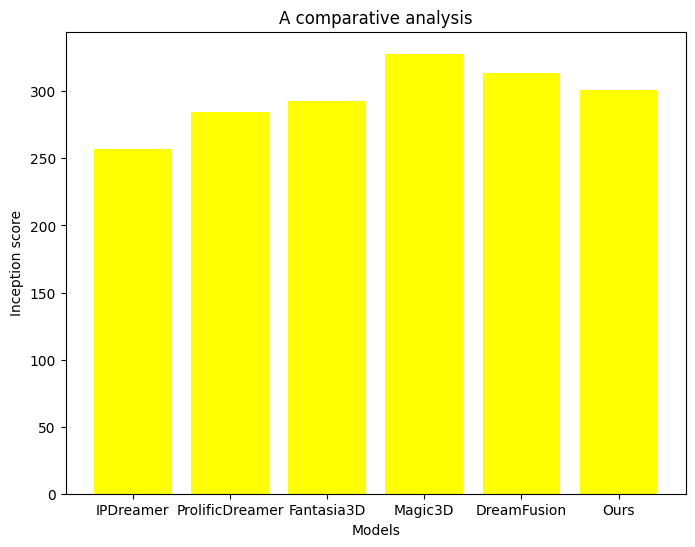

In [ ]:
labels = ['IPDreamer', 'ProlificDreamer', 'Fantasia3D', 'Magic3D', 'DreamFusion', 'Ours']
values = [257.17, 284.52, 292.86, 328.00, 313.58, 300.78]


plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='yellow')


plt.xlabel('Models')
plt.ylabel('Inception score')
plt.title('A comparative analysis')

# Show plot
plt.show()

In [ ]:
def intersection_over_union(pred_mask, true_mask, threshold=0.1):
    inter = 0.0
    union = 0.0
    for i in range(len(true_mask)):
      if abs(pred_mask[i]-true_mask[i]) < threshold:
          inter+=1
          union+=1
      else:
          union+=2
    iou = inter/union
    return iou

In [ ]:
model.load_state_dict(torch.load(FLAGS.checkpoint,
                                     map_location=torch.device('cpu')),
                          strict=False)
print('---- Model loaded from checkpoint')

data = DataFetcher(FLAGS.eval_data,
                   stereo=FLAGS.cnn_type == 'STR',
                   compute_f1=FLAGS.num_samples)
data.setDaemon(True)
data.start()
data_number = data.number
print('---- Loading eval data')

for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    model.eval()
    all_dist_1, all_dist_2 = [], []
    total = 0.0
    for iters in range(data_number):
        torch.cuda.empty_cache()
        if FLAGS.cnn_type != 'STR':
            img_inp, y_train, data_id = data.fetch()
            img_inp, y_train = process_input(img_inp, y_train)
            pred_points = model(img_inp)[-1]
        gt_points = y_train[:, :3]
        points1 = np.array(gt_points).flatten()
        points2 = np.array(pred_points).flatten()
        iou = intersection_over_union(points1, points2)
        print('Sample = {}, Intersection over Union = {:.4f}'.format(iters + 1, iou))
        total += iou
    print('Mean = {:.4f}'.format(total/data_number))

---- Model loaded from checkpoint
---- Loading eval data


<ipython-input-52-bdb2a9d5494d>:9: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  data.setDaemon(True)


Sample = 1, Intersection over Union = 0.6539
Sample = 2, Intersection over Union = 0.3879
Sample = 3, Intersection over Union = 0.3109
Sample = 4, Intersection over Union = 0.4003
Sample = 5, Intersection over Union = 0.4609
Sample = 6, Intersection over Union = 0.5149
Sample = 7, Intersection over Union = 0.3484
Sample = 8, Intersection over Union = 0.4031
Sample = 9, Intersection over Union = 0.4737
Sample = 10, Intersection over Union = 0.4077
Mean = 0.4362


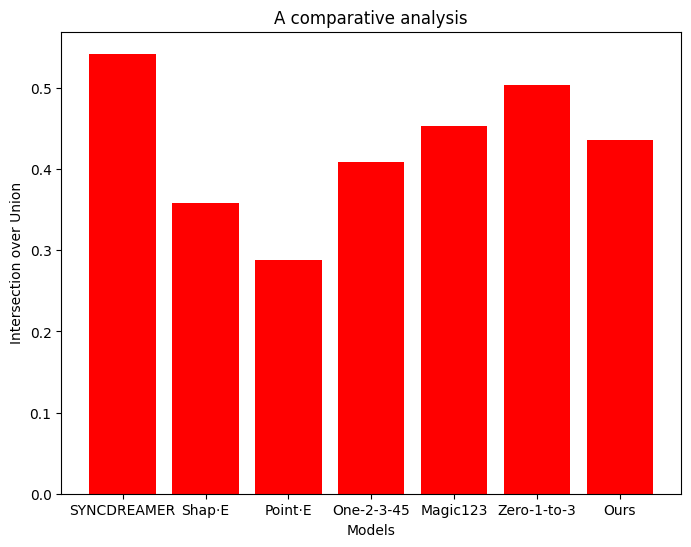

In [ ]:
labels = ['SYNCDREAMER', 'Shap·E', 'Point·E', 'One-2-3-45', 'Magic123', 'Zero-1-to-3', 'Ours']
values = [0.5421, 0.3584, 0.2875, 0.4086, 0.4528, 0.5035, 0.4362]


plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='red')


plt.xlabel('Models')
plt.ylabel('Intersection over Union')
plt.title('A comparative analysis')

# Show plot
plt.show()